## Assignment 4: Obsevational Studies and Applied ML

### Deadline
November 21st,11:59PM

### Important notes

Make sure you push on GitHub your notebook with all the cells already evaluated. Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented. Back up any hypotheses and claims with data, since this is an important aspect of the course. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.

Use this legendary link to create your repository: [link](https://classroom.github.com/g/YXtsr0QK)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

In [2]:
data_folder = './data/'

In [3]:
# Store a variable (after heavy computations) in a file
def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

In [4]:
# Load the variable using the file
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

<br>

---

<br>

## Task 1: Boosting the economy by incentivizing self-employment

Assume the biggest priority of the local government in 2018 is to increase per-capita income. To do so, the officials plan to adopt a strategy for incentivizing self-employment through a series of campaigns, educational programs, and dedicated funds.

Since it is unethical and impossible in this setting to run a controlled experiment involving citizens (e.g., fire employees and force them to self-employ), the officials have asked you, the data scientist, to establish the effect of self-employment on the economy, relying on observational data.

**A)** You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?

**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.

<br>

### Importing the data

<br>

In [5]:
task_1_folder = data_folder + 'Task1/'

Loading the csv file in a dataframe:

In [6]:
county_data = pd.read_csv(task_1_folder + 'acs2015_county_data.csv')
county_data.head(5)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


<br>

We can see that our dataframe contains a lot of information, not always relevant for this task. Let's filter it and keep what is usefull. To do so, we need to only keep some columns, using their names:

In [7]:
county_data.columns

Index(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

We can now create a new dataframe with all useful columns, being:
- CensusId
- State
- County
- Citizen
- IncomeErr	
- IncomePerCap	
- IncomePerCapErr
- SelfEmployed

In [8]:
employment_data = county_data[['CensusId', 'State', 'County', 'Citizen', 'IncomeErr', 'IncomePerCap',
                                         'IncomePerCapErr', 'SelfEmployed']]

employment_data.head(5)

,CensusId,State,County,Citizen,IncomeErr,IncomePerCap,IncomePerCapErr,SelfEmployed
0,1001,Alabama,Autauga,40725,2391.0,24974,1080,5.5
1,1003,Alabama,Baldwin,147695,1263.0,27317,711,5.8
2,1005,Alabama,Barbour,20714,2973.0,16824,798,7.3
3,1007,Alabama,Bibb,17495,3995.0,18431,1618,6.7
4,1009,Alabama,Blount,42345,3141.0,20532,708,4.2


<br>

#### **Question A:** 

Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,220 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?

<br>

Let's start by filtering out the data by keeping only the two useful columns that we are interested in:
- percentage of self-employed citizens
- per capita income

In [9]:
counties_employment = employment_data[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId'])
counties_employment.describe()

,IncomePerCap,SelfEmployed
count,3220.000000,3220.000000
mean,23981.771739,7.931801
std,6204.339960,3.914974
min,5878.000000,0.000000
25%,20238.500000,5.400000
50%,23460.000000,6.900000
75%,27053.250000,9.400000
max,65600.000000,36.600000


<br>

Let's now do a scatter plot of those two data in a graph. This will allow us to get a good visual idea of the dependency between them.

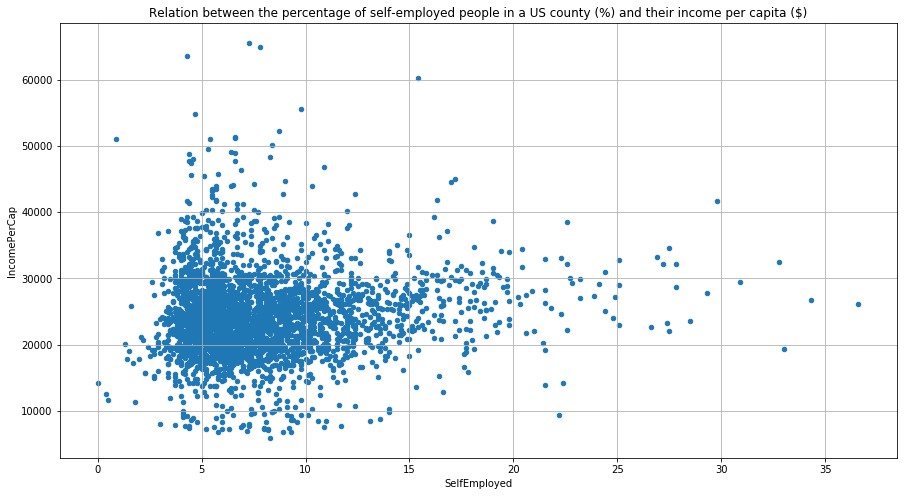

In [10]:
counties_employment.plot(kind='scatter',
             x='SelfEmployed', y='IncomePerCap', figsize=(15, 8), grid=True,
            title='Relation between the percentage of self-employed people in a US county (%) and their income per capita ($)')

Using the graph above as well as the decription of the dataframe, we can see that our data is pretty messy, but also that there aren't too many outliers (median is close to mean), so we can use Pearson (standard correlation coefficient, vulnerable around outliers).

In [11]:
counties_employment.corr('pearson')

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.087274
SelfEmployed,0.087274,1.000000


<br>

This pairwise correlation of our data shows us that **the two columns of our dataframe are almost not correlated at all**, as we get a value very close to `0`.

<br>

<br>

#### **Question B:** 

The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

<br>

In this part, we will be interested in a set of three counties:
- Wisconsin
- Tennessee
- Minnesota

Let's start by selecting the corresponding data and creating a new dataframe: 

In [12]:
set_A = county_data[(county_data.State == 'Wisconsin') |  (county_data.State == 'Tennessee') | (county_data.State == 'Minnesota')]
set_A = set_A[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId']) # Keeping only useful information

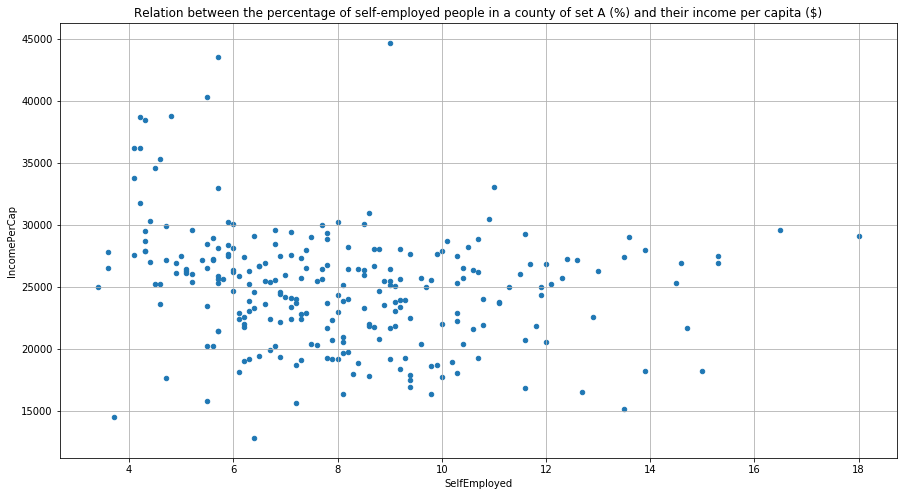

In [13]:
set_A.plot(kind='scatter',
            x='SelfEmployed', y='IncomePerCap', figsize=(15, 8), grid=True,
            title='Relation between the percentage of self-employed people in a county of set A (%) and their income per capita ($)')

Let's use Pearson to get a value and to actually compare the dependency in those counties:

In [14]:
set_A.corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,-0.202294
SelfEmployed,-0.202294,1.000000


We get a very low correlation score, which means there is not dependency between per-capita income on self-employment rates across all the counties in set A.

<br>

#### **Question C:** 

In which state within set A is the observed effect of self-employment on per-capita income the strongest?

<br>

In this part, we will are still interested of the set A, but we will analyze the dependency in each of the county separatly.

Let's start by selecting the corresponding data and creating three separate dataframe: 

In [15]:
# Wisconsin
wisconsin_data = county_data[county_data['State'] == 'Wisconsin'] # Filtering on the state name
wisconsin_data = wisconsin_data[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId']) # Keeping only useful information

# Tennesse
tennessee_data = county_data[county_data['State'] == 'Tennessee'] # Filtering on the state name
tennessee_data = tennessee_data[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId']) # Keeping only useful information

# Minnesota
minnesota_data = county_data[county_data['State'] == 'Minnesota'] # Filtering on the state name
minnesota_data = minnesota_data[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId']) # Keeping only useful information

<br>

Just as we did in the first question, let's do some scatter plot for each county to get some visual idea of the dependencies between per-capita income on self-employment rates across all three counties:

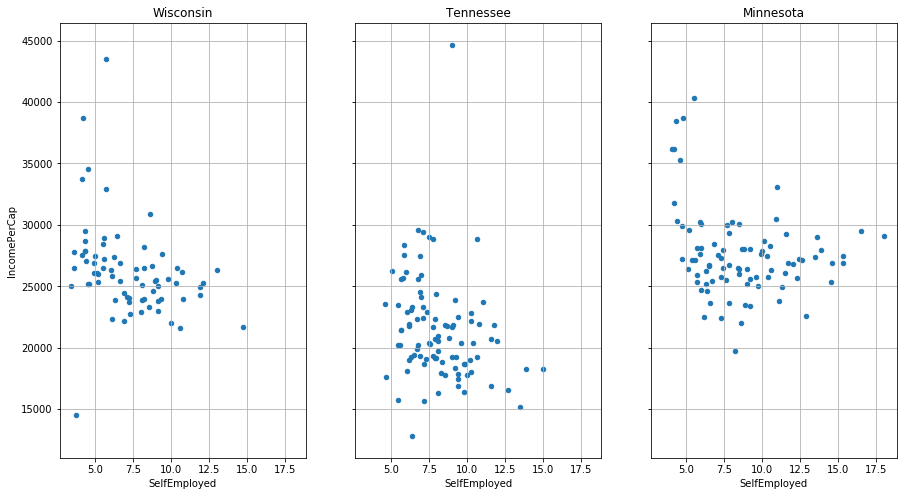

In [16]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

wisconsin_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[0], grid=True, title='Wisconsin', figsize=(15, 8))
tennessee_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[1], grid=True, title='Tennessee')
minnesota_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[2], grid=True, title='Minnesota')

<br>

Once again, our graphs don't give us a good dependency. Indeed, we have quite messy data withh no clear correlation.

Let's use Pearson to get a value and to actually compare the dependency in those county:

In [17]:
wisconsin_data.corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,-0.329053
SelfEmployed,-0.329053,1.000000


In [18]:
tennessee_data.corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.00000,-0.23836
SelfEmployed,-0.23836,1.00000


In [19]:
minnesota_data.corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,-0.253855
SelfEmployed,-0.253855,1.000000


<br>

Here, the correlation tables only shows us that there is actually no dependency between per-capita income on self-employment rates across all three counties of set A.

<br>

#### **Question D:** 

Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

>Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.

<br>

In this last part, we will be interested in a different set of three counties:
- New Jersey
- Kansas
- Rhode Island

Let's start by quantifying the dependency of per-capita income on self-employment rates across all the counties in set B:

In [20]:
set_B = county_data[(county_data.State == 'New Jersey') |  (county_data.State == 'Kansas') | (county_data.State == 'Rhode Island')]
set_B = set_B[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId']) # Keeping only useful information

<br>

Just like in the previous question, we will start by plotting the relation between the percentage of self-employed people in counties of set B and their income per capita:

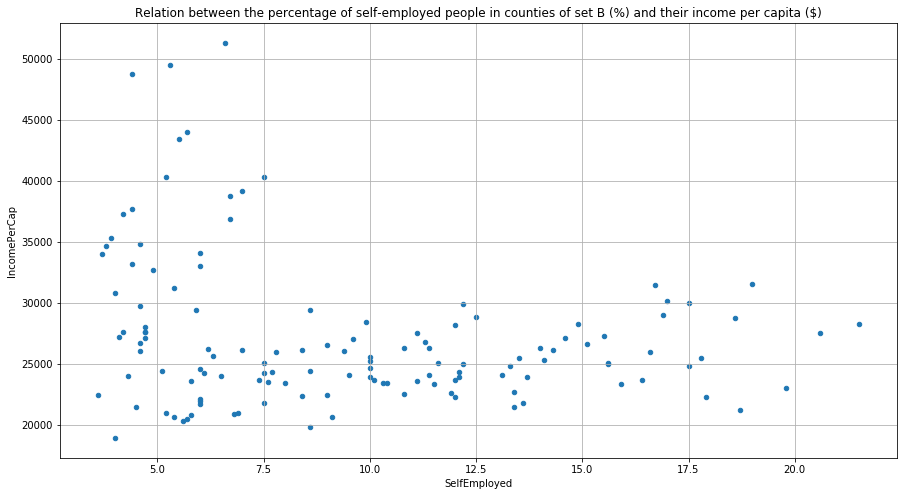

In [21]:
set_B.plot(kind='scatter',
            x='SelfEmployed', y='IncomePerCap', figsize=(15, 8), grid=True,
            title='Relation between the percentage of self-employed people in counties of set B (%) and their income per capita ($)')

In [22]:
set_B.corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,-0.232221
SelfEmployed,-0.232221,1.000000


<br>

Once again, we get a very low correlation score, which means there is not dependency between per-capita income on self-employment rates across all the counties in set B.

<br>

Let's see in which state within set B is the observed effect of self-employment on per-capita income the strongest:

In [23]:
# New Jersey
new_jersey_data = county_data[county_data['State'] == 'New Jersey'] # Filtering on the state name
new_jersey_data = new_jersey_data[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId']) # Keeping only useful information

# Kansas
kansas_data = county_data[county_data['State'] == 'Kansas'] # Filtering on the state name
kansas_data = kansas_data[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId']) # Keeping only useful information

# Rhode Island
rhode_island_data = county_data[county_data['State'] == 'Rhode Island'] # Filtering on the state name
rhode_island_data = rhode_island_data[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId']) # Keeping only useful information

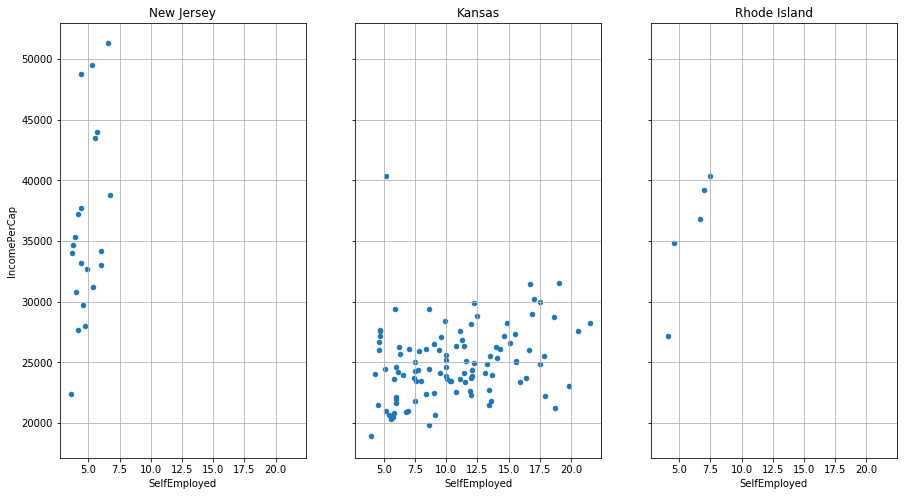

In [24]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

new_jersey_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[0], grid=True, title='New Jersey', figsize=(15, 8))
kansas_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[1], grid=True, title='Kansas')
rhode_island_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[2], grid=True, title='Rhode Island')

In [25]:
new_jersey_data.corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.480448
SelfEmployed,0.480448,1.000000


In [26]:
kansas_data.corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.258103
SelfEmployed,0.258103,1.000000


In [27]:
rhode_island_data.corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.902179
SelfEmployed,0.902179,1.000000


<br>

---

<br>

## Task 2: All you need is love… And a dog!

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

**A)** Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.

**B)** Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.

**C)** Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.

**D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

You are allowed to use the scikit-learn library to implement your classifiers.

> A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. 

First of all we will load the csv file 'aac_intakes_outcomes' as required. Since we only need some specific features described previously, we will then extract and store the selected features data.

In [28]:
# Load the dataset
task_2_folder = data_folder + 'task2/'
data = pd.read_csv(task_2_folder+'aac_intakes_outcomes.csv.zip')

In [29]:
# Select features described in the Task
extr_data = data[['animal_type','intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake','age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome','age_upon_outcome_(years)','outcome_type' ]]

Now that we have the data, we will create the 'output' vector containing a '1' value if the outcome is 'Adopted' and 0 otherwise. We will then obivously remove the 'outcome_type' feature to have a correct training set without the result.

So for the next of the exercie, **class 1** will be adopted and **class 0** not adopted.

In [30]:
# Convert outpt feature to 1 if Adoption and 0 otherwise
y = np.where(extr_data['outcome_type']=='Adoption', 1, 0)
# Remove the output feature in the training set (X)
extr_data = extr_data.drop('outcome_type', axis=1)

We would like to have a training dataset composed only of quantitative values. We'll then turn the Categorical features into numerical columns. 

In [31]:
print("Before transformation of categorical features \nNumber of features in dataset : %d" % (extr_data.shape[1]))

Before transformation of categorical features 
Number of features in dataset : 10


In [32]:
# Turn the categorical data into numerical
X = pd.get_dummies(extr_data)

In [33]:
X.head(5)

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,2017,1.0,10.0,0.588194,10.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2014,2.0,7.0,1.259722,7.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2014,3.0,6.0,1.113889,6.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2014,1.0,10.0,4.970139,10.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2013,1.0,16.0,0.119444,16.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [34]:
print("After transformation of categorical features \nNumber of features in dataset : %d" % (X.shape[1]))

After transformation of categorical features 
Number of features in dataset : 32


We can see that the transformation is increasing the dimension size of the training set. Indeed there is a multiplication factor of 3. For example the animal type feature could be 'Bird', 'Cat', 'Dog' or 'Other'. The operation is then turning the 1 column type into 4 numerical (boolean) features. 

Now the dataset needs to be splitted into a Training set part (80%) and a Test set (20%). 
To avoid bias and to have a generalized model, we would like to split randomly. 

We will then keep the indexes of the selected samples (for the training set) and use them to associate with the y output vector, and to get the rest for the test set.

In [35]:
# Split dataset : 80% for training and 20% for test
train=X.sample(frac=0.8,random_state=100)
test=X.drop(train.index)

In [36]:
# Use the index to associate each features vector to the output
y_train = y[train.index]
y_test = y[test.index]

In [37]:
print("Size of initial dataset : %d " %(len(X)))
print("Training set 80/100 perc., Size : %d " %(len(train)))
print("Test set 20/100 perc., Size : %d " %(len(test)))

Size of initial dataset : 79672 
Training set 80/100 perc., Size : 63738 
Test set 20/100 perc., Size : 15934 


We now want to standardize the dataset. in order to have a mean of 0 and a standard deviation of 1 for each feature. This will improve the efficiency of the ML model.

In [38]:
train.head(5)

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
69004,2017,1.0,0.038356,0.779167,0.038356,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
17025,2014,1.0,2.000000,2.237500,2.000000,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
27714,2015,1.0,2.000000,7.104861,2.000000,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
64559,2017,2.0,1.000000,2.222917,2.000000,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
23592,2014,1.0,0.164384,1.989583,0.164384,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [39]:
# Normalize by substracting the mean and diving by the difference between min and max, for each column.
train_norm = (train - train.mean()) / (train.std())
test_norm = (test - train.mean()) / (train.std())

Note : The mean value and max-min value should be taken from the training set. 
Indeed, assuming that this is a real case, then we should not normalize using the test data. 
The values from the training set are approved and correct, while the test set are not, which could then corrupt some samples of the test set. (If we use the mean of the test set, and some of the test samples are really noisy and not adequate, then it will influence the mean and the normalization.) 

__Thats is why we normalize the test set using the mean/max/min from the training set.__

In [40]:
train_norm.head()

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
69004,1.198929,-0.279536,-0.716274,-0.380531,-0.726451,-0.066186,1.307948,-1.154665,-0.241989,-0.063253,...,1.536485,-0.681192,-0.437423,-0.403593,-0.304395,2.759400,-0.373605,-0.742003,-0.68841,-0.304395
17025,-1.104370,-0.279536,-0.039612,-0.345679,-0.051408,-0.066186,1.307948,-1.154665,-0.241989,-0.063253,...,1.536485,-0.681192,-0.437423,-0.403593,-0.304395,-0.362392,-0.373605,-0.742003,1.45260,-0.304395
27714,-0.336604,-0.279536,-0.039612,-0.229357,-0.051408,-0.066186,-0.764544,0.866038,-0.241989,-0.063253,...,-0.650826,-0.681192,2.286079,-0.403593,-0.304395,-0.362392,-0.373605,1.347683,-0.68841,-0.304395
64559,1.198929,1.920374,-0.384558,-0.346028,-0.051408,-0.066186,-0.764544,0.866038,-0.241989,-0.063253,...,-0.650826,1.467992,-0.437423,-0.403593,-0.304395,-0.362392,2.676583,-0.742003,-0.68841,-0.304395
23592,-1.104370,-0.279536,-0.672801,-0.351604,-0.683082,-0.066186,1.307948,-1.154665,-0.241989,-0.063253,...,-0.650826,-0.681192,-0.437423,2.477704,-0.304395,-0.362392,-0.373605,-0.742003,1.45260,-0.304395


Here we can see that the normalization is well performed for each column. For the categorical column like "animal_type_Cat" containing only 0 and 1, we can see that there is only 2 different probabilities.

In [41]:
train_norm.mean().head()

intake_year                -9.576467e-15
intake_number               5.525278e-15
age_upon_intake_(years)     1.384616e-13
time_in_shelter_days       -1.021216e-15
age_upon_outcome_(years)    1.736350e-13
dtype: float64

In [42]:
(train_norm.std()).head()

intake_year                 1.0
intake_number               1.0
age_upon_intake_(years)     1.0
time_in_shelter_days        1.0
age_upon_outcome_(years)    1.0
dtype: float64

For the training set we can see that the mean for each column is indeed closed to 0 (really small), and the standard deviation is 1.

In [43]:
test_norm.mean().head()

intake_year                -0.008904
intake_number              -0.002718
age_upon_intake_(years)    -0.012157
time_in_shelter_days        0.006579
age_upon_outcome_(years)   -0.011696
dtype: float64

In [44]:
(test_norm.std()).head()

intake_year                 1.002597
intake_number               1.016344
age_upon_intake_(years)     0.989885
time_in_shelter_days        0.980199
age_upon_outcome_(years)    0.989825
dtype: float64

For the test set we can see that the mean for each column is indeed closed to 0 but less small than the training set, and the standard deviation is close to 1 but less precise.

This is because we are using the values from the training set. If we had more data then the differences should be minimal. This method is more safe to avoid outliers and wrong values from the test set. (In this case we are simulating the test set so this was not really a problem).

> We now have a correct dataset splitted in training part and test part with standardized values.
We will then use this data correctly prepared to train and implement machine learning models.

__B)__ Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.

In [45]:
# Create the model with lbfgs to handle L2 penalty
logistic = LogisticRegression(penalty='l2',solver='lbfgs', max_iter = 500)

In [46]:
# Train the model
logistic.fit(train_norm,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
logistic.predict_proba(train_norm)

array([[0.90072205, 0.09927795],
       [0.18913461, 0.81086539],
       [0.49588333, 0.50411667],
       ...,
       [0.25475007, 0.74524993],
       [0.40292267, 0.59707733],
       [0.23945586, 0.76054414]])

In [48]:
# Apply the logistic regression on the test set
y_pred = logistic.predict(test_norm)

In [49]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

A confusion matrix C is such that Ci,j is equal to the number of observations known to be in group i but predicted to be in group j.
Thus in binary classification, the count of true negatives (TN) is C0,0, false negatives(FN) is C1,0, true positives (TP) is C1,1 and false positives (FP) is C0,1.

We define the **Recall** such as **Proportion of data correcly classified in class 1**.

\begin{equation*}Recall = \frac{TP}{(TP + FN)} \end{equation*}

And **Precision** the **proportion of data in class 1 correctly classified overall data in class 1**.

\begin{equation*}Precision = \frac{TP}{(TP + FP)} \end{equation*}

The F1 score is a measure of a test's accuracy. It considers both the precision P and the recall R of the test to compute the score. The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

\begin{equation*}F1 =2 * \frac{Precision * Recall}{(Precision + Recall)} \end{equation*}


In [50]:
# Compute de confusion matrix
conf_matrice = confusion_matrix(y_test,y_pred)
conf_matrice

array([[7646, 1579],
       [1223, 5486]])

In [51]:
# Manually compute the conf_matrice
TP = sum(np.where((y_pred == y_test) & (y_pred == 1) >= 0.5, 1, 0))
TN = sum(np.where((y_pred == y_test) & (y_pred == 0) >= 0.5, 1, 0))
FP = sum(np.where((y_pred != y_test) & (y_pred == 1) >= 0.5, 1, 0))
FN = sum(np.where((y_pred != y_test) & (y_pred == 0) >= 0.5, 1, 0))

print(TN, FP, FN, TP)

7646 1579 1223 5486


In [52]:
Recall = TP / (TP + FN)
Precision = TP / (TP + FP)
F1 = 2*Precision*Recall/(Precision+Recall)

print("Precision: %0.2f" % (Precision))
print("Recall: %0.2f" % (Recall))
print("F1: %0.2f" % (F1))

Precision: 0.78
Recall: 0.82
F1: 0.80


Above we used a decision threshold of 0,5. Now we are going to vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [53]:
Precision_threshold_class0 = np.zeros(10)
Recall_threshold_class0 = np.zeros(10)
F1_threshold_class0 = np.zeros(10)

Precision_threshold_class1 = np.zeros(10)
Recall_threshold_class1 = np.zeros(10)
F1_threshold_class1 = np.zeros(10)
Accuracy = np.zeros(10)

y_pred = logistic.predict_proba(test_norm)

for i in range(0, 10):
    threshold = i/10;
    # Apply the model to test set and apply the decision threshold
    y_pred_threshold = np.where(y_pred[:,1] >= threshold, 1, 0)
    y_pred_threshold_class0 = np.where(y_pred[:,0] <= threshold, 1, 0)
    
    # Confusion matrix class 1
    TP = sum(np.where((y_pred_threshold == y_test) & (y_pred_threshold == 1) >= 0.5, 1, 0))
    TN = sum(np.where((y_pred_threshold == y_test) & (y_pred_threshold == 0) >= 0.5, 1, 0))
    FP = sum(np.where((y_pred_threshold != y_test) & (y_pred_threshold == 1) >= 0.5, 1, 0))
    FN = sum(np.where((y_pred_threshold != y_test) & (y_pred_threshold == 0) >= 0.5, 1, 0))
    
    #Compute the precision, recall, F1 and accuracy for class 1
    Precision_threshold_class1[i] = TP / (TP + FP)
    Recall_threshold_class1[i] = TP / (TP + FN)
    F1_threshold_class1[i] = 2*Precision_threshold_class1[i]*Recall_threshold_class1[i]/(Precision_threshold_class1[i]+Recall_threshold_class1[i])
    Accuracy[i] = sum((y_pred_threshold == y_test))/len(y_test)*100 
     
    # Confusion matrix class 0
    TP = sum(np.where((y_pred_threshold_class0 == y_test) & (y_pred_threshold_class0 == 1) >= 0.5, 1, 0))
    TN = sum(np.where((y_pred_threshold_class0 == y_test) & (y_pred_threshold_class0 == 0) >= 0.5, 1, 0))
    FP = sum(np.where((y_pred_threshold_class0 != y_test) & (y_pred_threshold_class0 == 1) >= 0.5, 1, 0))
    FN = sum(np.where((y_pred_threshold_class0 != y_test) & (y_pred_threshold_class0 == 0) >= 0.5, 1, 0))
    
    #Compute the precision, recall, F1 and accuracy for class 0
    Precision_threshold_class0[i] = TN / (TN + FN)
    Recall_threshold_class0[i] =  TN / (TN + FP)
    F1_threshold_class0[i] = 2*Precision_threshold_class0[i]*Recall_threshold_class0[i]/(Precision_threshold_class0[i]+Recall_threshold_class0[i])

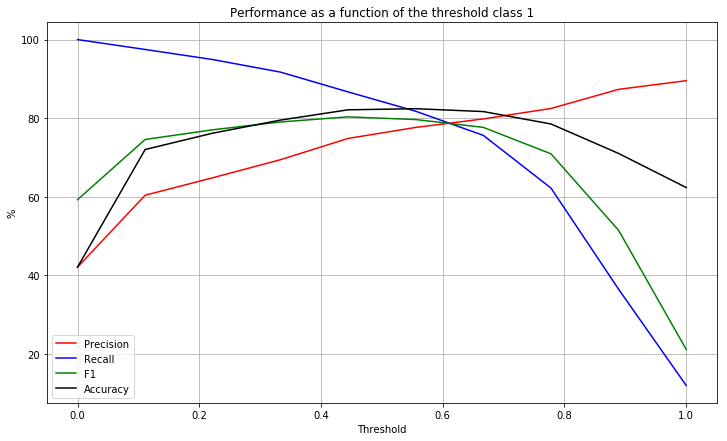

In [54]:
# Plot the performance measurment as function of the threshold
t = np.linspace(0,1,10)
plt.figure(figsize=(12,7))
plt.plot(t, 100*Precision_threshold_class1, 'r') 
plt.plot(t, 100*Recall_threshold_class1, 'b') 
plt.plot(t, 100*F1_threshold_class1, 'g')
plt.plot(t, Accuracy,'k')
plt.grid(axis='both')
plt.xlabel('Threshold')
plt.legend(['Precision','Recall','F1','Accuracy'])
plt.ylabel('%')
plt.title('Performance as a function of the threshold class 1')
plt.show()

The curves are not really smooth because we used a step of 0,1. But as we can see all curves in one graph, it can be very easy to analyse and compare. First of all there is only the precision curve which stay rising. Indeed, the more the threshold is close to 1, the more the model classify the feature in class 1, and so increas the precision.

Nevertherless, the Recall function is downwarding. Because at the contrary, the more the threshold is close to 1, the more we classify feature of class 0 in class 1.
If we look at the F1 curve, it never reach 1. Its maximal value is 80 for a threshold of 0,5.

Total accuracy is maximised for a threshold of 0.6, but this does not maximise either the precision or recall.

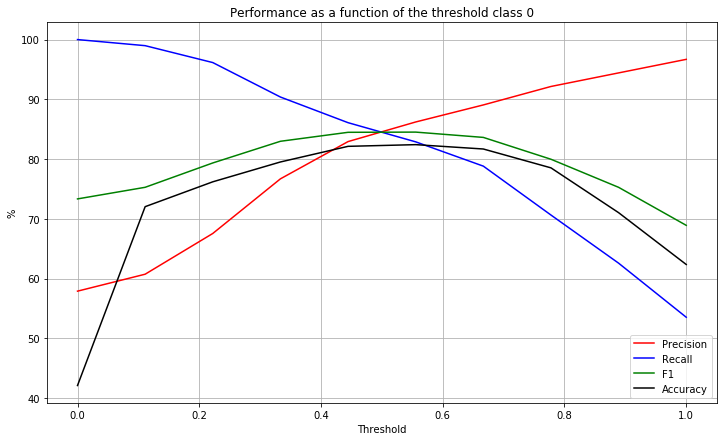

In [55]:
# Plot the performance measurment as function of the threshold
t = np.linspace(0,1,10)
plt.figure(figsize=(12,7))
plt.plot(t, 100*Precision_threshold_class0, 'r') 
plt.plot(t, 100*Recall_threshold_class0, 'b') 
plt.plot(t, 100*F1_threshold_class0, 'g')
plt.plot(t, Accuracy,'k')
plt.grid(axis='both')
plt.xlabel('Threshold')
plt.legend(['Precision','Recall','F1','Accuracy'])
plt.ylabel('%')
plt.title('Performance as a function of the threshold class 0')
plt.show();

As we can see, recall and precision curves cross each other with the 0.5 threshold. The accurcay does not change and the f1 measure is quite the same. To get more precision on which of those measuring scores to use, we are going to have a look to the precision-recall curve plot.

<function matplotlib.pyplot.show(*args, **kw)>

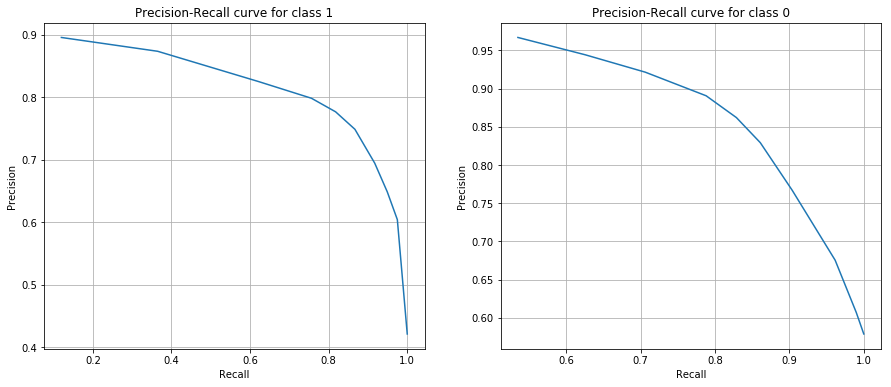

In [56]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(Recall_threshold_class1,Precision_threshold_class1)
plt.grid(axis='both')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for class 1')
plt.show

plt.subplot(122)
plt.plot(Recall_threshold_class0,Precision_threshold_class0)
plt.grid(axis='both')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for class 0')
plt.show

Precision is sort of like accuracy but it looks only at the data you predicted positive (in this example you’re only looking at data where you predict a adoption). Recall is also sort of like accuracy but it looks only at the data that is “relevant”. But there will be always a tradeoff between classifying correctly all data points of the class OR making sure each class contains data point of only one class.

If you change a binary classifier parameter (the threshold for a logistic regression classifier in our case), it turns out the precision and recall will change. But if the precision increases (the chance of adopting an animal), the recall (the number of betting opportunities to get an animal adopted) will decrease. And vice versa

As the shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption, the best threshold is the one that give an acceptable tradeoff between Recall and Precision. We do not want to put to sleep an adoptable animal, so focus on the **recall**. In our case, the best threshold parameter would be for a recall value of 0.8, which corresponds to a threshold around **0.6** for class 1, being adopted (where recall and precision curves crossed each other in the first graph). If we look at class 0, it might be a threshold around 0.5. For a 0.55 threshold, the F1 score is really close to its maximal value. So it helps us to comfirm in our choice.

**Question C)** Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.

In [57]:
K = [1, 5, 10, 15, 20, 25, 30]

In [58]:
train_norm.shape

(63738, 32)

In [59]:
features = list(train_norm)

So actually, in our train set, there are 32 differents features available (i.e 32 columns). So we are going to train a model using the k best defined by greedy backward selection.

The Recursive Feature Elimination (RFE) method is a feature selection approach. It works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [60]:
# Create a base classifier
model = LogisticRegression(penalty='l2',solver='lbfgs', max_iter = 500);
CV_scores = np.zeros(len(K));

i=0;
for k in K :
    # create the RFE model and select 3 attributes
    rfe = RFE(model, k, step=1, verbose=0)
    rfe = rfe.fit(train_norm, y_train)
    print('Number of feature selected : %d ' %rfe.n_features_)
    
    # Do the cross validation for model 
    cross_val = cross_val_score(rfe, train_norm, y_train, cv=5, scoring='f1',n_jobs=-1)
    print(cross_val)
    
    # Compute the mean of the CV and keep it
    CV_scores[i] = cross_val.mean()
    i += 1;

Number of feature selected : 1 


/Users/eliottjoulot/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/eliottjoulot/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/eliottjoulot/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/eliottjoulot/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/eliottjoulot/anaconda3/li

[0. 0. 0. 0. 0.]
Number of feature selected : 5 
[0.74297879 0.74207257 0.74328749 0.76103551 0.74390144]
Number of feature selected : 10 
[0.79063884 0.78868672 0.79201869 0.79239871 0.79338843]
Number of feature selected : 15 
[0.79024831 0.78877799 0.79167041 0.79219268 0.79346264]
Number of feature selected : 20 
[0.79173464 0.79234381 0.79251395 0.79511363 0.79675676]
Number of feature selected : 25 
[0.79238095 0.79186624 0.79409913 0.79698167 0.79780141]
Number of feature selected : 30 
[0.79244941 0.79157247 0.79384228 0.79662235 0.7975858 ]


As we can see above, for each cross validation made with k selected feature, the cross validation returns an array of scores of the estimator for each fold of the cross validation.

So after each CV, we compute the means of the score and plot below the cross validation score depending on the number of features selected

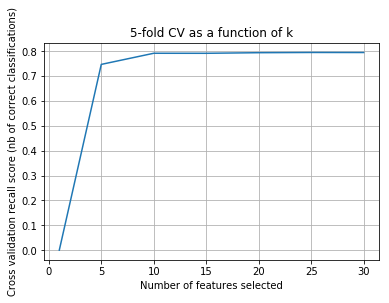

In [61]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation recall score (nb of correct classifications)")
plt.grid(axis='both')
plt.title('5-fold CV as a function of k')
plt.plot(K, CV_scores)
plt.show()   

So as we can see, the model rapidly reaches its best performance for k=10. So only one third of the feature is sufficient to build our model for an accuracy of 80%. Using more than the 10 best feature will not bring more usefull information and will increase the computational cost. Now let's have a look at those best 10 features

In [62]:
# Do the feature selection for k=10
rfe = RFE(model, 10, step=1, verbose=0)
rfe = rfe.fit(train_norm, y_train)
best_10 = rfe.support_
print(best_10)

[False False  True  True  True False False False False False False False
 False False False False False False  True False  True  True  True  True
 False False False False False  True  True False]


In [63]:
# Get the index of the best features in the list
best_features_index = [i for i, x in enumerate(best_10) if x]
best_features_index = np.array(best_features_index)
best_features_index

array([ 2,  3,  4, 18, 20, 21, 22, 23, 29, 30])

In [64]:
# Get the best 10 features
best_features = [features[index] for index in best_features_index]
best_features

['age_upon_intake_(years)',
 'time_in_shelter_days',
 'age_upon_outcome_(years)',
 'intake_type_Owner Surrender',
 'intake_type_Stray',
 'intake_type_Wildlife',
 'sex_upon_intake_Intact Female',
 'sex_upon_intake_Intact Male',
 'sex_upon_outcome_Neutered Male',
 'sex_upon_outcome_Spayed Female']

So now we are able to see in more details which features are the most relevants for an adoption. At first comes the age, which might not be surprising. An old animal has less chance to get adopted than a young one. Then comes the time remains in the shelter. 

The three following features are concerning the intake type. For example, an animal strayed by its owner can make people more sentimental toward it. So people might have more pity for those animals.  Then the sex at the intake and outcome. It seems that people are also interested int the sex and either the animal is neutered or not. That is an important fact to take into account : knowing if the animal you are going to adopt can reproduce or not (and the choice can depends on if you want to let this happend or not). 

A surprise in this features is the lack of the type (such as bird, dog or cat). Indeed the type seems to be important in a choice like type_bird. Because a  bird is really different than a cat or a dog (animals which require more contraints than a bird), this is why we though this features could be powerfull to seperate better the data. Or maybe because when people come at the shelter they already know which type of animal they want to adopt, this features canno't be very helpfull in prediction.

Once, the final model is the once train on the best 10 feature with a threshold of 0.55 :

In [65]:
# Select the 10 best features
train_features = train_norm[best_features].copy();

# Train the model based on the selected features
logistic.fit(train_features,y_train);

# Apply the model to the test set
predicted_labels = logistic.predict_proba(test_norm[best_features]);

threshold = 0.55;


y_class1 = np.where(predicted_labels[:,1] >= threshold, 1, 0);
y_class0 = np.where(predicted_labels[:,0] <= threshold, 1, 0);

# Class 1 score
TP = sum(np.where((y_class1 == y_test) & (y_class1 == 1) >= threshold, 1, 0))
TN = sum(np.where((y_class1 == y_test) & (y_class1 == 0) >= threshold, 1, 0))
FP = sum(np.where((y_class1 != y_test) & (y_class1 == 1) >= threshold, 1, 0))
FN = sum(np.where((y_class1 != y_test) & (y_class1 == 0) >= threshold, 1, 0))
Recall_logistic = TP / (TP + FN)
Precision_logistic = TP / (TP + FP)
F1_logistic = 2*Precision_logistic*Recall_logistic/(Precision_logistic+Recall_logistic)
Accuracy_logistic = (TP+TN)/len(y_test)
print("Accuracy class 1: %0.2f" % (Accuracy_logistic))
print("Precision class 1: %0.2f" % (Precision_logistic));
print("Recall    class 1: %0.2f" % (Recall_logistic));
print("F1        class 1: %0.2f" % (F1_logistic));

# Class 0 score
TP = sum(np.where((y_class0 == y_test) & (y_class0 == 1) >= threshold, 1, 0))
TN = sum(np.where((y_class0 == y_test) & (y_class0 == 0) >= threshold, 1, 0))
FP = sum(np.where((y_class0 != y_test) & (y_class0 == 1) >= threshold, 1, 0))
FN = sum(np.where((y_class0 != y_test) & (y_class0 == 0) >= threshold, 1, 0))
Recall = TN / (TN + FN)
Precision = TN / (TN + FP)
F1 = 2*Precision*Recall/(Precision+Recall)
Accuracy = (TP+TN)/len(y_test)
print("\nAccuracy class 0: %0.2f" % (Accuracy))
print("Precision class 0: %0.2f" % (Precision));
print("Recall    class 0: %0.2f" % (Recall));
print("F1        class 0: %0.2f" % (F1));


Accuracy class 1: 0.82
Precision class 1: 0.78
Recall    class 1: 0.79
F1        class 1: 0.79

Accuracy class 0: 0.82
Precision class 0: 0.81
Recall    class 0: 0.87
F1        class 0: 0.84


As we can see, the precision of both class is quite the same. Whereas the recall is much more high for class 0. SO globally our model is 80% accurate.


> **Question D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

As the grid search is a heavy computational process we would to implement it once, and then store the result in a variable file using pickle. That is why we implemented a function 'get_n_estimators_gridsearch' which will load the pickle file if it is available and will generate it otherwise. 

In [66]:
def get_n_estimators_gridsearch():
    # Try to load the file alrezady computed 'n_estimators'
    try:
        return load_pickle('n_estimators')
    # If the file does not exist, compute it
    except (FileNotFoundError, EOFError) as e:
        vec_n_estimators = []
        vec_precision = []
        vec_recall = []
        
        # For each value of n _estimators, we implement the model and compute the value of precision & recall.
        # We store it in lists
        for val_n_estimators in range(10, 400, 10):
            random_forest = RandomForestClassifier(n_estimators= val_n_estimators)
            
            precision_rf = cross_val_score(random_forest, train_norm, y_train, cv=5, scoring="precision")
            recall_rf = cross_val_score(random_forest, train_norm, y_train, cv=5, scoring="recall")
            
            vec_n_estimators.append(val_n_estimators)
            vec_precision.append(precision_rf.mean())
            vec_recall.append(recall_rf.mean())
        
        #Compute F1 score for all values using previously computed Recall and Precision
        vec_F1 = []
        for i in range(len(vec_precision)):
            vec_F1.append( 2*(vec_precision[i]*vec_recall[i])/(vec_precision[i]+ vec_recall[i]) )
        
        # Create a DataFrame with Recall/Precision/F1 score for each value of n_estimators
        df_n_estimators = pd.DataFrame({'n_estimators': vec_n_estimators,
                                            'Precision': vec_precision,
                                            'Recall': vec_recall,
                                            'F1 score': vec_F1})
        # Save the computed Dataframe into a pickle file
        save_pickle(df_n_estimators, 'n_estimators')
        return df_max_depth


The cost increases when we set a greater value for n_estimations.

In [67]:
# Load the data describing the model for each value of n estimator
df_n_estimators = get_n_estimators_gridsearch()

In [68]:
df_n_estimators.head()

,F1 score,Precision,Recall,n_estimators
0,0.790834,0.797474,0.784304,10
1,0.796577,0.796799,0.796355,20
2,0.798203,0.795054,0.801376,30
3,0.798235,0.794059,0.802455,40
4,0.797570,0.793144,0.802046,50


We select the best n_estimators by taking the maximum value of F1 score and its corresponding n_estimator.

In [69]:
best_n_estimators = df_n_estimators['n_estimators'][df_n_estimators['F1 score'].idxmax()]
print("The best F1 score is using : n_estimators = %d" % best_n_estimators)

The best F1 score is using : n_estimators = 310


In [70]:
val_best_n_estimators = df_n_estimators['F1 score'][df_n_estimators['F1 score'].idxmax()]
print("The best F1 score is %f" % val_best_n_estimators)

The best F1 score is 0.799882


Text(0.5,1,"Gridsearch, F1 score with variable 'n estimators'")

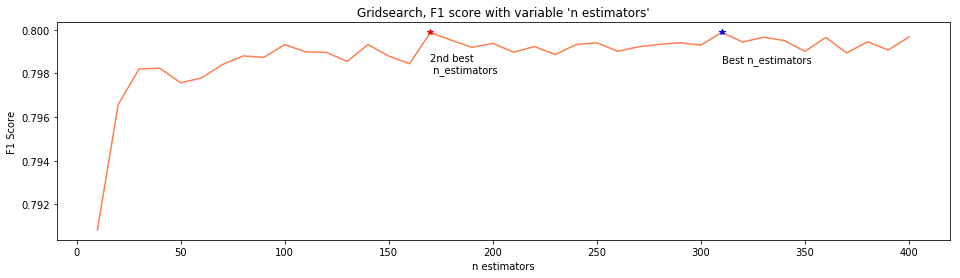

In [71]:
fig, axes = plt.subplots()
fig.set_size_inches(16,4)

axes.plot(df_n_estimators['n_estimators'], df_n_estimators['F1 score'], color='coral') 

axes.plot(best_n_estimators, val_best_n_estimators,'b*')
axes.annotate("Best n_estimators", (310, 0.7985))

axes.plot(170, val_best_n_estimators,'r*')
axes.annotate("2nd best\n n_estimators", (170, 0.798))

axes.set_xlabel("n estimators")
axes.set_ylabel("F1 Score")
axes.set_title("Gridsearch, F1 score with variable 'n estimators'")

We can see in this graph that some values are close to the optimal. Indeed the n_estimator = 170 is really close. It could then be interesting to take this one instead of n_estimator = 310, because this will reduce the complexity of the model and the computational cost. There is then a tradeoff. We will continue with the maximum value which is 310.

We will now use the same approach to select the bext 'max_depth' value, using the preselected n_estimators = 310.

In [72]:
def get_max_depth_gridsearch(chosen_n_estimators):
    # Try to load the file alrezady computed 'max_depth'
    try:
        return load_pickle('max_depth')
    # If the file does not exist, compute it
    except (FileNotFoundError, EOFError) as e:
        vec_max_depth = []
        vec_precision_max_depth = []
        vec_recall_max_depth = []
        
        # For each value of max_depth, we implement the model and compute the value of precision & recall.
        # We store it in lists
        for val_max_depth in range(3, 20, 1):
            random_forest = RandomForestClassifier(n_estimators= chosen_n_estimators, max_depth = val_max_depth)
            
            precision_rf = cross_val_score(random_forest, train_norm, y_train, cv=5, scoring="precision")
            recall_rf = cross_val_score(random_forest, train_norm, y_train, cv=5, scoring="recall")
            
            vec_max_depth.append(val_max_depth)
            vec_precision_max_depth.append(precision_rf.mean())
            vec_recall_max_depth.append(recall_rf.mean())

        
        #Compute F1 score for all values using previously computed Recall and Precision
        vec_F1 = []
        for i in range(len(vec_precision_max_depth)):
            vec_F1.append( 2*(vec_precision_max_depth[i]*vec_recall_max_depth[i])/(vec_precision_max_depth[i]+ vec_recall_max_depth[i]) )
        
        # Create a DataFrame with Recall/Precision/F1 score for each value of max_depth
        df_max_depth = pd.DataFrame({'max_depth': vec_max_depth,
                                    'Precision': vec_precision_max_depth,
                                    'Recall': vec_recall_max_depth,
                                    'F1 score': vec_F1})
        # Save the computed Dataframe into a pickle file
        save_pickle(df_max_depth, 'max_depth')
        return df_max_depth

In [73]:
# Load the data describing the model for each value of max_depth
max_depth = get_max_depth_gridsearch(chosen_n_estimators = best_n_estimators)

In [74]:
max_depth.head()

,F1 score,Precision,Recall,max_depth
0,0.804029,0.751664,0.864237,3
1,0.812976,0.758475,0.875916,4
2,0.821255,0.768919,0.881235,5
3,0.822440,0.769159,0.883653,6
4,0.828469,0.774801,0.890125,7


In [75]:
best_maxdepth = max_depth['max_depth'][max_depth['F1 score'].idxmax()]
print("The best F1 score is using : max_depth = %d" % best_maxdepth)

The best F1 score is using : max_depth = 14


In [76]:
val_best_maxdepth = max_depth['F1 score'].max()
print("The best F1 score is %f" % val_best_maxdepth)

The best F1 score is 0.838470


Text(0.5,1,"Gridsearch, F1 score with variable 'max depth'")

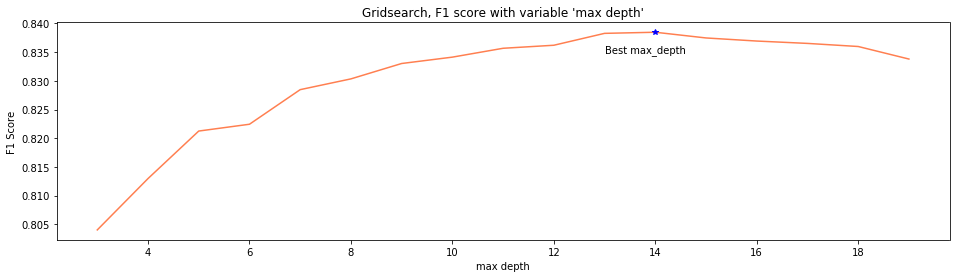

In [77]:

fig, axes = plt.subplots()
fig.set_size_inches(16,4)

axes.plot(max_depth['max_depth'], max_depth['F1 score'], color='coral') 

axes.plot(best_maxdepth, val_best_maxdepth,'b*')
axes.annotate("Best max_depth", (13, 0.835))

axes.set_xlabel("max depth")
axes.set_ylabel("F1 Score")
axes.set_title("Gridsearch, F1 score with variable 'max depth'")

After the computations and the selection we can say that the gridsearch of parameters 'n_estimators' and 'max_depth' gives :
- __n_estimators = 310__ 
- __max_depth = 14__.

For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

In [78]:
# Implement the model using the selected parameters and the standardized training set
random_forest = RandomForestClassifier(n_estimators= best_n_estimators, max_depth = best_maxdepth)
random_forest.fit(train_norm, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=310, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [79]:
# Compute the output for the test set
pred_rf = random_forest.predict_proba(test_norm)

In [80]:
# Categorize the output (1 or 0) using the threshold 0.5
pred_rf_val = np.where(pred_rf[:,1] >= 0.5, 1, 0)

We are now able to construct the confusion matrix.
- True positive : y_predicted = y_reference = 1
- True negative : y_predicted = y_reference = 0
- False positive : y_predicted(=1)  != y_reference 
- False negative : y_predicted(=0)  != y_reference

In [81]:
true_positive = sum(np.where((pred_rf_val == y_test) & (pred_rf_val == 1) >= 0.5, 1, 0))
true_negative = sum(np.where((pred_rf_val == y_test) & (pred_rf_val == 0) >= 0.5, 1, 0))
false_positive = sum(np.where((pred_rf_val != y_test) & (pred_rf_val == 1) >= 0.5, 1, 0))
false_negative = sum(np.where((pred_rf_val != y_test) & (pred_rf_val == 0) >= 0.5, 1, 0))

In [82]:
confusion_matrix_RF = pd.DataFrame(columns=["y_pred = 1", "y_pred = 0"], index=["y_ref = 1","y_ref = 0"], data=[[true_positive,false_positive],[false_negative,true_negative]])

In [83]:
confusion_matrix_RF

,y_pred = 1,y_pred = 0
y_ref = 1,6015,1559
y_ref = 0,694,7666


In [84]:
rf_accuracy = (true_positive+true_negative)/len(pred_rf_val)

In [85]:
print("The Accuracy is : %f" % (rf_accuracy)) 

The Accuracy is : 0.858604


In [86]:
rf_precision = (true_positive)/(true_positive + false_positive)

In [87]:
print("The Precision is : %f " % (rf_precision))

The Precision is : 0.794164 


In [88]:
rf_recall = (true_positive)/(true_positive + false_negative)

In [89]:
print("The Recall is : %f " % (rf_recall))

The Recall is : 0.896557 


In [90]:
rf_f1score = 2*(rf_precision*rf_recall)/(rf_precision+rf_recall)

In [91]:
print("The F1 Score is : %f " % (rf_f1score))

The F1 Score is : 0.842260 


In [92]:
data_compare = [ [Accuracy_logistic,rf_accuracy],[Precision_logistic,rf_precision],[Recall_logistic,rf_recall],[F1_logistic,rf_f1score]]
compare_models_DF = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1-score"], columns=["Logistic Regression","Random Forest"], data=data_compare)

In [93]:
compare_models_DF

,Logistic Regression,Random Forest
Accuracy,0.817874,0.858604
Precision,0.778412,0.794164
Recall,0.793263,0.896557
F1-score,0.785767,0.842260


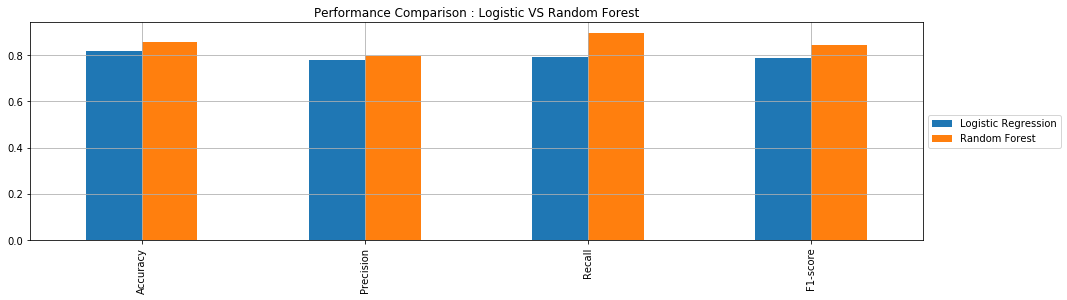

In [94]:
compare_models_DF.plot(kind='bar', figsize=(16,4), title="Performance Comparison : Logistic VS Random Forest", grid=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

We can observe that the __Random Forest model is much more efficient__ than the Logistic Regression model. Indeed except the Precision where it is slightly better, the Accuracy, Recall and F1-score have a really higher value. 
The Random Forest is a more complex one with some well selected parameters. 

The Recall is also really high (0.897 for Random Forest) which is why it is definitely the best model (among the 2) for the shelter, as the recall is more important for our case. There will be less error and less "accidentally" killed animals. 